# Ruled-based Model

In this notebook, we elucidate how we developed a rule-based model for recommendation of clothing pieces for commuting by bike.This notebook covers the following steps: 

1. Importing libraries
2. Generating input data & collecting location/weather data from OpenWeatherMap API
3. Data pre-processing and exploratory data analysis
4. Model development 
5. Model evaluation
6. Model deployment
   
## 1. Importing libraries

In [1]:
import random
from random import randint
import requests, json
import pandas as pd
from datetime import datetime, timezone
import pytz # this lib allows accurate and cross platform timezone calculations with python
import numpy as np
import config # to run this, you should have the congif file in the working directory
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Generating input data & collecting location/weather data from OpenWeatherMap API

In the first step of this section, we define a function 'input_generator' by assinging values to variables

In [2]:
def input_generator():
    location_list=('Atlanta','Berlin','Hamburg','München','Freiburg','Melbourne', 'Moskau') # example list 
    location=location_list[randint(0,6)]
    time=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)# timezone is irrelevant for our objectives
    time=time.replace(hour=randint(time.hour,23))
    heaviness_of_trip=randint(1,3)
    if heaviness_of_trip==1: heaviness_of_trip="easy"
    if heaviness_of_trip==2: heaviness_of_trip="normal"
    if heaviness_of_trip==3: heaviness_of_trip="hard"
    heat_preference=randint(-5,5)
    sex=randint(1,3)
    if sex==1: sex="m"
    if sex==2: sex="f"
    if sex==3: sex="d"
    df=pd.DataFrame({
    "location" : [location],
    "time": [time], 
    "heaviness_of_trip": [heaviness_of_trip], 
    "heat_preference" : [heat_preference],
    "sex": [sex]
    })
    return df

In the next step, we define a function to generate multiple input data by iterating over rows and appending input data into the dataframe.

In [4]:
#autogenerate DataFrame with multiple input
def generate_multi_input(a):
    df=input_generator()
    for t in range(a-1): #a Trips today (it is asking for one person, so the sex, the heat preference and the ocation ist not changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'location']=df['location'].iloc[0]
        df.at[t+1,'heat_preference']=df['heat_preference'].iloc[0]
        df.at[t+1,'sex']=df['sex'].iloc[0]
    return df

In this step, we use python requests library to retrieve relevant data from the API. For this, we invoked the HTTP method Get to retrieve data.

In [9]:
def weather(df):
    base_url = "http://api.openweathermap.org/data/2.5/weather?" # assigning current weather url to base_url 
    future_url="https://api.openweathermap.org/data/2.5/forecast?"# assigning future weather url to future_url
    df['weather']=None
    df['temperature']=None
    #for every row in the dataframe
    for i in range(len(df.index)) :
        # Give city name
        city_name = df['location'].iloc[i]
        df_time=df['time'].iloc[i].replace(tzinfo=None)
        now=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)
        # complete_url stores the api address for the current weather data
        complete_current_url = base_url + "appid=" + config.api_key + "&q=" + city_name + "&units=metric"
        # complete url stores the api address for the future weather data
        complete_future_url = future_url + "q=" + city_name + "&appid=" + config.api_key + "&units=metric"
        # expected response object
        response = requests.get(complete_current_url).json() #response of the current weather data
        response_future = requests.get(complete_future_url).json() # response of the future weather (3 hours weather forecast)
        time_forecast=datetime.strptime(response_future['list'][0]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        time_forecast2=datetime.strptime(response_future['list'][1]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        # json method of response object
        # convert json format data into
        # python format data
        if (abs((df_time-now).total_seconds()) <abs((time_forecast-df_time).total_seconds()))&(abs((df_time-now).total_seconds()) <abs((time_forecast2-df_time).total_seconds())): #is the time closer to now then to any of the future forecast
            df.at[i,'weather']=response['weather'][0]['main']
            df.at[i,'temperature']=response['main']['temp']
            df.at[i,'windspeed']=response['wind']['speed']
        else:
            for a in range(10): # looks up to 30 hours in the future
                time_forecast=datetime.strptime(response_future['list'][a]['dt_txt'],'%Y-%m-%d %H:%M:%S')
                substrakt=time_forecast-df_time
                if abs(substrakt.total_seconds())<5400: ## Forecast is just every 3 hours, so it is always taking the closest one
                    df.at[i,'weather']=response_future['list'][a]['weather'][0]['main']
                    df.at[i,'temperature']=response_future['list'][a]['main']['temp']
                    df.at[i,'windspeed']=response_future['list'][a]['wind']['speed']
                    break   
    return df

The following function is used to generate a evaluation datasets, sex is male, cause the evalution set is specific builded for Matze.<p> There is no random state added, cause it would be needed to implement into the input_generator() function, which has more uses then just building the evaluationset

In [83]:
# generating dataset for different weather scenarios
def generate_evaluationset():
    df=input_generator()
    df.at[0,'heat_preference']=0
    df.at[0,'sex']='m'
    for t in range(14): # a trip for today (asking one person, thus, sex, the heat preference and the location isn't changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'heat_preference']=0
        df.at[t+1,'sex']='m'
    return df

<hr style="border:2px solid gray"> </hr>   
   
## 3. Data pre-processing and exploratory data analysis (EDA)

Data cleaning: The following function with for loop iterates over the rows in dataframe and detects missing values or inaccurate/corrupt records and replaces them with 'incomplete data' enabling the non-stop provision of data for the app.
1. if heat preference is missing --> 'incomplete data'
2. if sex is missing --> 'incomplete data'
3. if time is missing --> 'incomplete data'
4. if heavines of trip is missing --> 'incomplete data'
5. if location is missing --> 'incomplete data'

In [12]:
def input_cleaning(df):
    df['heat_preference'] = df['heat_preference'].fillna('incomplete data') 
    df['time'] = df['time'].fillna(datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None))
    df['sex'] = df['sex'].fillna('incomplete data')
    df['heaviness_of_trip'] = df['heaviness_of_trip'].fillna('incomplete data')
    df['location'] = df['location'].fillna('incomplete data')
    return df

In general most of the data is collected in the first steps using the application. so actually there is no further preprocessing needed.
In future version it is possible to integrate Geolocations instead of names for the location.

Data visualisation is not needed in this state of the model, it will be done later during the evaluation

<hr style="border:2px solid gray"> </hr>   
   
## 5. Model development

In this section, we develop a model, based on the rules extracted from decision trees. The rules define the clothing items for different bodyparts based on five distinct features. We took the following arithmetic expression 'temp + heatperception – (if female ==2) > current_temp' as the main logic. The thresholds were picked based on empirical observation (personal experience) and intuition. All functions use dataframes as input and append new columns by extending the frame.

In [16]:
def t_p_s_h(df,i): # t_p_s_h stands for temperature_heat preference_sex_heaviness_of_trip
    red=0. # reducing parameter
    if df['sex'].iloc[i]=='f':
        red=2.
    heaviness=0.
    if df['heaviness_of_trip'].iloc[i]=='hard':
        heaviness=2.
    else:
        if df['heaviness_of_trip'].iloc[i]=='easy':
            heaviness=-2.
    t_p_s_h=float(df['temperature'].iloc[i])+float(df['heat_preference'].iloc[i])-red+heaviness
    return t_p_s_h

In [17]:
# defining the rules for headwear
def headwear(df):
   df['headwear']=3
   for i in range(len(df.index)):
      if t_p_s_h(df,i)>10: # if temp above 10C, the model recommends nothing but Helmet
            df.at[i,'headwear']=1
      else:
         if t_p_s_h(df,i)>2:
            df.at[i,'headwear']=2
   return df

In [18]:
# defining the rules for sunglasses
def sunglasses(df):
    df['sunglasses']=0
    for i in range(len(df.index)):
        if df['weather'].iloc[i]=='Clear': # sun or clear is the only split for this tree
            df.at[i,'sunglasses']=1
    return df

In [19]:
# defining the rules for neck
def neck(df):
    
    df['neck']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 degrees no buff
            df.at[i,'neck']=1
        else :
            if t_p_s_h(df,i)>12:
                if (df['weather'].iloc[i]=='Rain')|(df['windspeed'].iloc[i]>15): # if temp > 15C & windy or rainy, then buff, else none.
                    df.at[i,'neck']=2
                else :
                    df.at[i,'neck']=1
            else :
                if (t_p_s_h(df,i)>0) | (df['weather'].iloc[i]=='Clear'): # if temp > 0C & sunny, then buff, otherwise warm scarf
                    df.at[i,'neck']=2
    return df

In [20]:
# defining the rules for shirt and singlet 
def inner_layer(df):
    df['shirt']=0
    df['singlet']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # 10 C is the split. If temp is above 10, wear shirt. Under 10C wear a singlet.
            df.at[i,'shirt']=1
        else:
            df.at[i,'singlet']=1
    
    return df

In [21]:
#defining the rules for the upper body clothing pieces
def upper_body_outer_layers(df):
    df['upper_body_second_layer']=3
    df['upper_body_third_layer']=3
    df['upper_body_outer_layer']=5
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>25:
            df.at[i,'upper_body_second_layer']=1
            df.at[i,'upper_body_third_layer']=1
            df.at[i,'upper_body_outer_layer']=1
        else:
            if t_p_s_h(df,i)>20:
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=3
                else:
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=1
            else:
                if t_p_s_h(df,i)>10:
                    if df['weather'].iloc[i]=='Rain':
                        df.at[i,'upper_body_second_layer']=3
                        df.at[i,'upper_body_third_layer']=1
                        df.at[i,'upper_body_outer_layer']=4
                    else:
                        df.at[i,'upper_body_second_layer']=2
                        df.at[i,'upper_body_third_layer']=2
                        df.at[i,'upper_body_outer_layer']=1
                else:
                    if t_p_s_h(df,i)>0:
                        if df['weather'].iloc[i]=='Clear':
                            df.at[i,'upper_body_second_layer']=2
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
                        else:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=1
                            df.at[i,'upper_body_outer_layer']=5
                    else:
                        if t_p_s_h(df,i)>-5:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
    return df

In [22]:
#defining the rules for handwear
def hands(df):
    df['hands']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>15: # first split is at 10 C, model recommends no handwear.
            df.at[i,'hands']=1
        else:
            if (t_p_s_h(df,i)>11):
                if(df['windspeed'].iloc[i]>15):
                    df.at[i,'hands']=2
                else:
                    df.at[i,'hands']=1
            else:
                if (t_p_s_h(df,i)>8):
                    df.at[i,'hands']=2
    return df

In [23]:
# defining the rules for raintrousers
def raintrousers(df):
    df['raintrousers']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)<17: # 17C is the first split. If temp < 17 and rainy, it recommends raintrousers.
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'raintrousers']=1
    return df

In [24]:
# defining the rules for socks
def socks(df):
    df['socks']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22: # if temp > 22 and rainy, the model recommends socks
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'socks']=2
            else:
                if df['sex'].iloc[i]=='f': # if temp > 22, weather state is not rainy & user is female, then no socks, for male with socks
                    df.at[i,'socks']=1
                else:
                    df.at[i,'socks']=2
        else:
            if t_p_s_h(df,i)>0:       # above 0 normal socks, under 0 woolen socks
                df.at[i,'socks']=2
    return df

In [25]:
#defining the rules for shoes
def shoes(df):
    df['shoes']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # if the temp > 22 C & rainy, the model recommends low shoes
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'shoes']=2
            else:
                    df.at[i,'shoes']=1 # if temp > 22, the model recommends summer shoes
        else:
            if t_p_s_h(df,i)>2: # if temp > 7 & rainy, the model recommends rainshoes
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'shoes']=4 # if not rainy, then normal shoes. if under 7 C, then boots
                else:
                    df.at[i,'shoes']=2

    return df

In [26]:
# concatenating the output of the logic of the decision trees into single list
def get_clothing_output_rbm(df):
    headwear(df)
    sunglasses(df)
    neck(df)
    inner_layer(df)
    upper_body_outer_layers(df)
    hands(df)
    raintrousers(df)
    socks(df)
    shoes(df)
    #df['control']=0
    #for i in range(len(df.index)):
    #   df.at[i,'control']=t_p_s_h(df,i)
    return df

In [27]:
# using function 'add_dummy(df)'for testing purposes.<p>
def add_dummy(df):
    df['headwear']=1
    df['sunglasses']=0
    df['neck']=1
    df['singlet']=0
    df['shirt']=0
    df['upper_body_second_layer']=1
    df['upper_body_third_layer']=1
    df['upper_body_outer_layer']=1
    df['hands']=1
    df['raintrousers']=0
    df['socks']=1
    df['shoes']=1
    for i in range(len(df.index)):
        df.at[i,'headwear']=randint(1,4)
        df.at[i,'sunglasses']=randint(0,1)
        df.at[i,'neck']=randint(1,3)
        df.at[i,'singlet']=randint(0,1)
        df.at[i,'shirt']=randint(0,1)
        df.at[i,'upper_body_second_layer']=randint(1,3)
        df.at[i,'upper_body_third_layer']=randint(1,3)
        df.at[i,'upper_body_outer_layer']=randint(1,5)
        df.at[i,'hands']=randint(1,3)
        df.at[i,'raintrousers']=randint(0,1)
        df.at[i,'socks']=randint(1,2)
        df.at[i,'shoes']=randint(1,3)
    return df

<hr style="border:2px solid gray"> </hr>  

## 6. Model evaluation

- Evaluation from technical perspective:
We generated fifteen different weather scenarios (combination of six features) for hot, warm, breezy, and cold seasons to ask a user to fill in the table with clothing pieces that s/he would pick for given scenarios. We compared a user’s clothing selections with clothing recommendations from the rule-based model. The model scored 73% (double check), outperforming our initial prediction accuracy score goal for three percent. 
 
- Evaluation from user's point of view:
Afterward, we provided a user with clothing predictions from the rule-based model to evaluate the recommendations on a scale of way too cold’, ‘a little too cold’, ‘just right’, ‘a little too hot’, ‘way too hot’. The successful model will achieve a perfect clothing feedback score of above 70% of app uses (still needs to be conducted).

In [85]:
# generating an evaluation set for user to fill out
evaluation_technical=weather(generate_evaluationset())


In [79]:
# comparing user-chosen clothing items to given scenarios to clothing outputs recommended by rule-based model
evaluation_user=get_clothing_output_rbm(evaluation_technical)
evaluation_user.to_csv('evaluation_user_csv_v1.csv')# saving the evaluation set into a csv file

Reading in the provided dataframe of Matze and get a second dataframe with just the used Input from his evaluationset

In [ ]:
matze=pd.read_csv('evaluation_user_matze.csv', sep=";")
matze
matze_input=matze.iloc[: , :8]
matze_input['heat_preference']=0
matze_input

In the Following Code section we are going through the provided dataset from Matze and try to find the best fit for his Heat_preference

the heatpreference is:  -5  the score is:  0.5944444444444444
the heatpreference is:  -4  the score is:  0.6222222222222222
the heatpreference is:  -3  the score is:  0.6444444444444444
the heatpreference is:  -2  the score is:  0.65
the heatpreference is:  -1  the score is:  0.6666666666666667
the heatpreference is:  0  the score is:  0.6833333333333333
the heatpreference is:  1  the score is:  0.7166666666666667
the heatpreference is:  2  the score is:  0.7055555555555555
the heatpreference is:  3  the score is:  0.7111111111111111
the heatpreference is:  4  the score is:  0.7111111111111111
the heatpreference is:  5  the score is:  0.6944444444444444


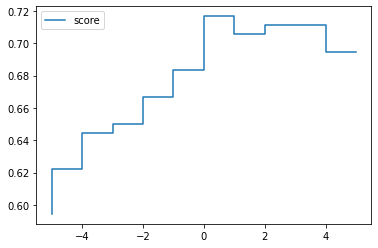

In [32]:
sco={}
score_df=pd.DataFrame.from_dict(sco)
score_df['score']=0
for i in range(-5,6):
    matze_input['heat_preference']=i
    comp=get_clothing_output_rbm(matze_input).compare(matze,keep_shape=True)
    comp=comp.loc(axis=1)[:,'self']
    comp.columns=comp.columns.droplevel(-1)
    comp.drop('heat_preference',axis=1, inplace=True)
    score=1-(comp.notna().sum().sum())/180
    score_df.at[i,'score']=score
    print('the heatpreference is: ', i , ' the score is: ', score)
#comp
#score
#print(score_df)
score_df.plot(drawstyle='steps')
plt.show()

The following lines are manly to understand the usage with the dataframe and to find out how to plot the data

In [86]:
matze_input['heat_preference']=1
best=get_clothing_output_rbm(matze_input).compare(matze,keep_shape=True)
#print(best)
best=best.loc(axis=1)[:,'self']
best.columns=best.columns.droplevel(-1)
best.drop('heat_preference',axis=1, inplace=True)
best.drop(columns=['location','time','heaviness_of_trip','sex','weather','temperature','windspeed'], inplace=True)
best_wrong=best.notna().sum().sum() # counting the wrongs
score=1-best_wrong/180
#print(score)
#print(best.notna().sum().sort_values())
#best.columns


Showing a bar with number of wrong recommendations per category

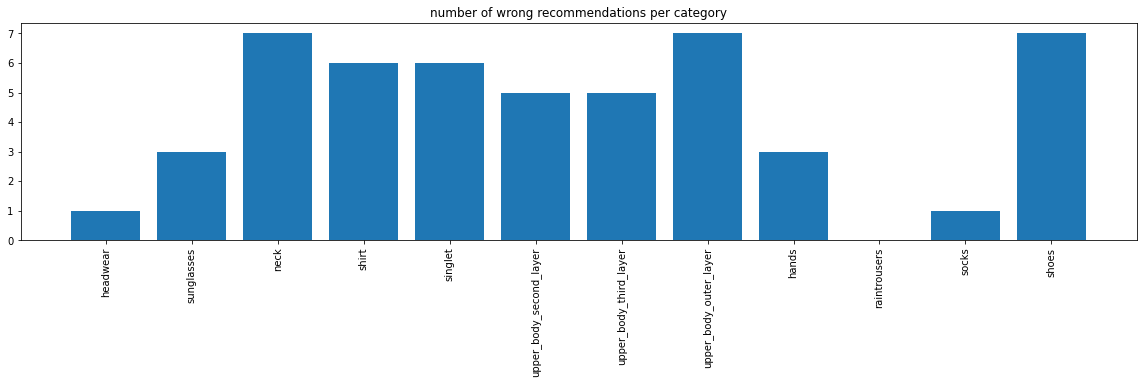

In [87]:

fig, axs = plt.subplots(1, 1, figsize=(20, 4), sharey=True)
plt.bar(best.columns,best.notna().sum())
plt.xticks(rotation=90)
#axs.title('number of wrong recommendations')
#best.notna().sum().sort_values().plot(drawstyle="bar", linewidth=2, title='number of wrong recommendations')
plt.title('number of wrong recommendations per category')
plt.show()

Showing a bar with the percantage of correct recommendations per category

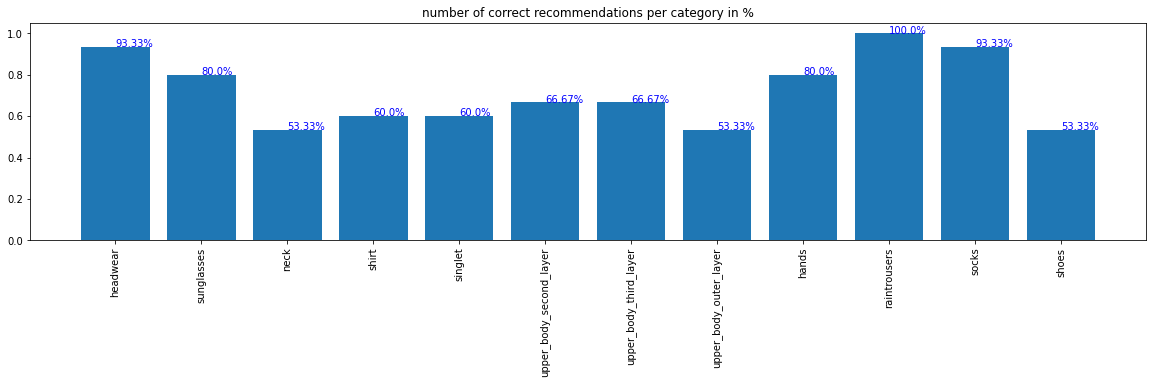

In [75]:
fig, axs = plt.subplots(1, 1, figsize=(20, 4), sharey=True)
plt.bar(best.columns,(1-(best.notna().sum()/15)))
for i, v in enumerate((1-(best.notna().sum()/15))):
    axs.text(i, v, str(round(v*100,2))+"%", 
            color = 'blue')
plt.xticks(rotation=90)
#axs.title('number of wrong recommendations')
#best.notna().sum().sort_values().plot(drawstyle="bar", linewidth=2, title='number of wrong recommendations')
plt.title('number of correct recommendations per category in %')
plt.show()

### Interpretation
The following is an analysis for the categories with the largest number of false recommendations.
1. shoes have a large number, because Matze always wears the same shoes. Our model predicts different types of shoes for winter, fall and summer conditions.
2.Neck has a huge number because Matze always wears the buff or no neck protection. In discussion with stakeholders we want to recommend warm scarves for some weather conditions. --> the number was higher at the beginning, I adjusted the thresholds a bit, so for a wider temperature range the buff is recommended.
3. shirt and singlet are actually difficult to analyze, because they are not recommended in the application. In this case, Matze always wears a shirt and never a singlet. I personally would do it that way, but in the stakeholder discussion it showed that people handle it differently.
4. Matze simply does not use sunglasses.
5. outer layers are better than expected, as we always recommend a set of the 3 outer layers, personal preferences can be very different. If you decide to wear anything else in the second layer, it has a big impact on the third and outer layer.




<hr style="border:2px solid gray"> </hr>  

## 7. Output concatenation
The function 'get_clothing(df)' outputs 3 recommendations in dataframes. 

- The first df recommends clothing items for current enquiry
- The second df recommends which clothing items to pack in a backpack
- The third one provides information on what to wear at which trip.

The functions recommendation_df(df)& recommendation_json(js) converts the input (either from a df or a json) into a json format required for the Flask API.

In [35]:
# get three lists for to wear now and to bring in the backpack and a full DF what to wear at which trip
def get_clothing(df):
    dic=['headwear','sunglasses','neck','singlet','shirt','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands','raintrousers','socks','shoes'] # all columns
    oneisnone=['headwear','neck','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands'] # all colums where 1 is the lowest possible output
    ##wear_now is the first clothing set from the first input beside when shoes and jacket are to big, they have to be wear them 
    wear_now=df.iloc[0:1].copy()
    ##in the backpack is all the other necessary clothes
    backpack_help=df.iloc[:,8:].copy()
    backpack=backpack_help.iloc[0:0].copy() # empty DF with column names
    for i in dic:
        if backpack_help[i].unique().max()==0|((i in oneisnone) & backpack_help[i].unique().max()==1): #if the maximum of the category is not wear any, stop here
            backpack.at[0,i]=None
        else:
            z=0
            while z<backpack_help[i].nunique():
                if backpack_help[i].unique()[z]!=0: #if the the newest item of the category is not to wear any, skip it
                    if ((i in oneisnone) & backpack_help[i].unique()[z]!=1):
                        backpack.at[z,i]=backpack_help[i].unique()[z]
                z=z+1
    ##if shoes or the outerlayer are bigger in the backpack we gonna wear the biggest one, so the backpack won't get to full
    if backpack_help['shoes'].unique().max()> wear_now['shoes'][0]:
        wear_now.at[0,'shoes']=backpack_help['shoes'].unique().max()
    backpack.at[:,'shoes']=None
    if backpack_help['upper_body_outer_layer'].unique().max()> wear_now['upper_body_outer_layer'][0]:
        wear_now.at[0,'upper_body_outer_layer']=backpack_help['upper_body_outer_layer'].unique().max()
    backpack.at[:,'upper_body_outer_layer']=None  
    backpack=backpack.replace({np.nan: None})
    #Ouput of all Clothing Sets in every trip, shoes and outerlayer must be the same as in the first trip
    clothing_per_trip=df
    clothing_per_trip.at[:,'shoes']=wear_now['shoes'][0]
    clothing_per_trip.at[:,'upper_body_outer_layer']=wear_now['upper_body_outer_layer'][0]

    return wear_now, backpack, clothing_per_trip


In [36]:
def recommendation_json(js):
    json_inp= pd.read_json(js, orient='index',convert_dates=['time'])  
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(input_cleaning(json_inp))))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json() # drop the nan from df
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

In [37]:
def recommendation_df(df):
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(input_cleaning(df))))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json()#(orient="columns")
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

## 8. Model deployment

Deployment is in the Flask_api.py
manly used is the function recommendation_json(js)

### Testing area

In [ ]:
#checking if the function is working as defined
a=generate_multi_input(4)
print(a)
#displaying data in json
a=a.to_json(orient="index",date_format='iso')
print(a)
#testing data with json input
json_inp=pd.read_json(a, orient='index',convert_dates=['time'])   
print(json_inp)
#testing the read in from different jsn formats
b={"0":{"location":"Freiburg"},"1":{"time":"2022-01-23T23:09:32.856Z"},"2":{"location":"Freiburg","time":"2022-01-23T22:09:32.867Z","heaviness_of_trip":"easy","heat_preference":-2,"sex":"m"},"3":{"location":"Freiburg","time":"2022-01-23T17:09:32.878Z","heat_preference":-2,"sex":"m"}}
c=json.dumps(b)
print(c)
json_inp= pd.read_json(c, orient='index',convert_dates=['time'])   
print(json_inp)

In [ ]:
#weather test
#two dataframes (one with just 1 input, and one with 6 input Trips)
test=weather(input_generator())
len(test.index)
test.to_json()
print(test.to_json())
print(test)
test2=weather(generate_multi_input(20))
test2.head()

In [ ]:
#Testing the input cleaner
input_cleaning(json_inp)
print(json_inp)

In [ ]:
#testing the model
test3=weather(generate_multi_input(20))
get_clothing_output_rbm(test3)